# Model inference

In the previous notebook, we saw how to do model inference on the test set. Here, we show how to load an already trained/fine-tuned model and a dataset and then do model inference.

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from mapreader import loader
from mapreader import classifier
from mapreader import load_patches
from mapreader import patchTorchDataset

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
##from scipy.interpolate import griddata
from torchvision import transforms

## Read patches (i.e., sliced images) and add metadata

First, we need to load a set of images/pathces. We use a CV model to do inference on these images.

In [5]:
myimgs = load_patches("./dataset/eg_slice_50_50/*PNG", 
                      parent_paths="./dataset/open_access_plant/*png")

In [6]:
imgs_pd, patches_pd = myimgs.convertImages(fmt="dataframe")
patches_pd.head()

,parent_id,image_path,min_x,min_y,max_x,max_y
patch-0-0-50-50-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50
patch-0-0-50-50-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50
patch-0-100-50-150-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150
patch-0-100-50-150-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150
patch-0-150-50-200-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,150,50,200


In `.add_metadata`:

```python
# remove duplicates using "name" column
if columns == None:
    columns = list(metadata_df.columns)

if ("name" in columns) and ("image_id" in columns):
    print(f"Both 'name' and 'image_id' columns exist! Use 'name' to index.")
    image_id_col = "name"
if "name" in columns:
    image_id_col = "name"
elif "image_id" in columns:
    image_id_col = "image_id"
else:
    raise ValueError("'name' or 'image_id' should be one of the columns.")
```

The dataframe should have either `name` or `image_id` column, and that column should be the image ID (NOT the path to the image).

In [7]:
# Rename image_path to image_id
# This is needed later (see `.add_metadata`)
patches_pd = patches_pd.reset_index()
patches_pd.rename(columns={"index": "image_id"}, 
                  inplace=True)
patches_pd.head()

,image_id,parent_id,image_path,min_x,min_y,max_x,max_y
0,patch-0-0-50-50-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50
1,patch-0-0-50-50-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50
2,patch-0-100-50-150-#2014-06-06_plant001_rgb.pn...,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150
3,patch-0-100-50-150-#2014-07-17_plant047_rgb.pn...,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150
4,patch-0-150-50-200-#2014-06-06_plant001_rgb.pn...,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,150,50,200


In [8]:
patches2infer = patches_pd[["image_path"]]
patches2infer

,image_path
0,C:\Users\ecorcoran\classification_phenotype_te...
1,C:\Users\ecorcoran\classification_phenotype_te...
2,C:\Users\ecorcoran\classification_phenotype_te...
3,C:\Users\ecorcoran\classification_phenotype_te...
4,C:\Users\ecorcoran\classification_phenotype_te...
...,...
215,C:\Users\ecorcoran\classification_phenotype_te...
216,C:\Users\ecorcoran\classification_phenotype_te...
217,C:\Users\ecorcoran\classification_phenotype_te...
218,C:\Users\ecorcoran\classification_phenotype_te...


## Add patches to `patchTorchDataset`

In [9]:
# ------------------
# --- Transformation
# ------------------
# FOR INCEPTION
#resize2 = 299
# otherwise:
resize2 = 224

# mean and standard deviations of pixel intensities in 
# all the patches in 6", second edition maps
normalize_mean = 1 - np.array([0.82860442, 0.82515008, 0.77019864])
normalize_std = 1 - np.array([0.1025585, 0.10527616, 0.10039222])
# other options:
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'val': transforms.Compose(
        [transforms.Resize((resize2, resize2)),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
        ]),
}


In [10]:
patches2infer_dataset = patchTorchDataset(patches2infer, 
                                          transform=data_transforms["val"])


## Load a classifier (normally trained in notebook 003)

In [11]:
myclassifier = classifier(device="default")
myclassifier.load("./models_plant_open/checkpoint_10.pkl")

[INFO] Device is set to cpu


In [12]:
# Add dataset to myclassifier
batch_size=64
myclassifier.add2dataloader(patches2infer_dataset, 
                            set_name="infer_test", 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=0)

[INFO] added 'infer_test' dataloader with 220 elements.



## Inference on `set_name`

In [13]:
myclassifier.inference(set_name="infer_test")

2022-01-14 16:03:10 AUTO-ATI04 [INFO] infer_test -- 11/11 --      64/220 ( 29.1%) -- 
Total time: 0m 19s



## Plot sample results

In [14]:
myclassifier.class_names

{0: 'No', 1: 'Plant'}

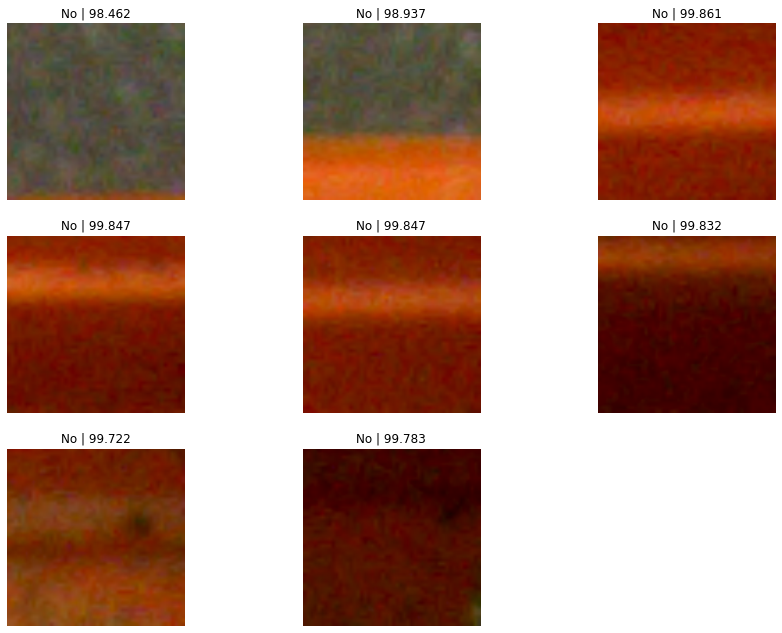

In [15]:
myclassifier.inference_sample_results(num_samples=8, 
                                      class_index=0, 
                                      set_name="infer_test",
                                      min_conf=50,
                                      max_conf=None)

## Add model inference outputs to `myimgs`

In [16]:
patches2infer['pred'] = myclassifier.pred_label
patches2infer['conf'] = np.max(np.array(myclassifier.pred_conf), 
                               axis=1)
patches2infer


,image_path,pred,conf
0,C:\Users\ecorcoran\classification_phenotype_te...,0,0.984618
1,C:\Users\ecorcoran\classification_phenotype_te...,0,0.989366
2,C:\Users\ecorcoran\classification_phenotype_te...,0,0.998607
3,C:\Users\ecorcoran\classification_phenotype_te...,0,0.998475
4,C:\Users\ecorcoran\classification_phenotype_te...,0,0.998468
...,...,...,...
215,C:\Users\ecorcoran\classification_phenotype_te...,0,0.998389
216,C:\Users\ecorcoran\classification_phenotype_te...,0,0.998500
217,C:\Users\ecorcoran\classification_phenotype_te...,0,0.999183
218,C:\Users\ecorcoran\classification_phenotype_te...,0,0.998543


In [17]:
patches_pd = \
    patches_pd.merge(patches2infer, 
                     how="outer",
                     on="image_path",
                     validate="1:1")

In [18]:
patches_pd.head()

,image_id,parent_id,image_path,min_x,min_y,max_x,max_y,pred,conf
0,patch-0-0-50-50-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50,0,0.984618
1,patch-0-0-50-50-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50,0,0.989366
2,patch-0-100-50-150-#2014-06-06_plant001_rgb.pn...,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150,0,0.998607
3,patch-0-100-50-150-#2014-07-17_plant047_rgb.pn...,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150,0,0.998475
4,patch-0-150-50-200-#2014-06-06_plant001_rgb.pn...,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,150,50,200,0,0.998468


In [19]:
myimgs.add_metadata(patches_pd, 
                    tree_level="child")

## Write outputs as CSVs, one file per image

In [20]:
imgs_pd, patches_pd = myimgs.convertImages(fmt="dataframe")
patches_pd.head()

,parent_id,image_path,min_x,min_y,max_x,max_y,image_id,pred,conf
patch-0-0-50-50-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50,patch-0-0-50-50-#2014-06-06_plant001_rgb.png#.PNG,0,0.984618
patch-0-0-50-50-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50,patch-0-0-50-50-#2014-07-17_plant047_rgb.png#.PNG,0,0.989366
patch-0-100-50-150-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150,patch-0-100-50-150-#2014-06-06_plant001_rgb.pn...,0,0.998607
patch-0-100-50-150-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150,patch-0-100-50-150-#2014-07-17_plant047_rgb.pn...,0,0.998475
patch-0-150-50-200-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,150,50,200,patch-0-150-50-200-#2014-06-06_plant001_rgb.pn...,0,0.998468


In [21]:
imgs_pd["name"] = imgs_pd["image_path"].apply(lambda x: os.path.basename(x))

In [22]:
imgs_pd

,parent_id,image_path,children,name
2014-06-06_plant001_rgb.png,None,C:\Users\ecorcoran\classification_phenotype_te...,[patch-0-0-50-50-#2014-06-06_plant001_rgb.png#...,2014-06-06_plant001_rgb.png
2014-07-17_plant047_rgb.png,None,C:\Users\ecorcoran\classification_phenotype_te...,[patch-0-0-50-50-#2014-07-17_plant047_rgb.png#...,2014-07-17_plant047_rgb.png


In [23]:
output_dir = "./infer_output_open_plant"
os.makedirs(output_dir, exist_ok=True)

In [24]:
for one_img in list(imgs_pd.index):
    # --- paths
    img_name = one_img.split(".")[0]
    patch2write = os.path.join(output_dir, f"patch_{img_name}.csv")
    sheet2write = os.path.join(output_dir, f"sheet_{img_name}.csv")
    # --- write outputs
    patches_pd[patches_pd["parent_id"] == one_img].to_csv(patch2write, index=False)
    imgs_pd[imgs_pd.index == one_img].to_csv(sheet2write, index=False)

## Load outputs and plot

Although we already have all the required dataframes/variables loaded, we re-load them here as this is a required step in most realistic applications.

In [25]:
myimgs = load_patches("./dataset/eg_slice_50_50/*PNG", 
                      parent_paths="./dataset/open_access_plant/*png")

In [27]:
# load the CSV files which contain predictions/confidence/...
path2patch = glob.glob("./infer_output_open_plant/*csv")

for path2metadata in path2patch:
    print(path2metadata)
    myimgs.add_metadata(metadata=path2metadata, 
                        tree_level="child", 
                        delimiter=",")

# or directly:
# myimgs.add_metadata(patches_pd, tree_level="child")

./infer_output_open_plant\patch_2014-06-06_plant001_rgb.csv
./infer_output_open_plant\patch_2014-07-17_plant047_rgb.csv
./infer_output_open_plant\sheet_2014-06-06_plant001_rgb.csv
./infer_output_open_plant\sheet_2014-07-17_plant047_rgb.csv


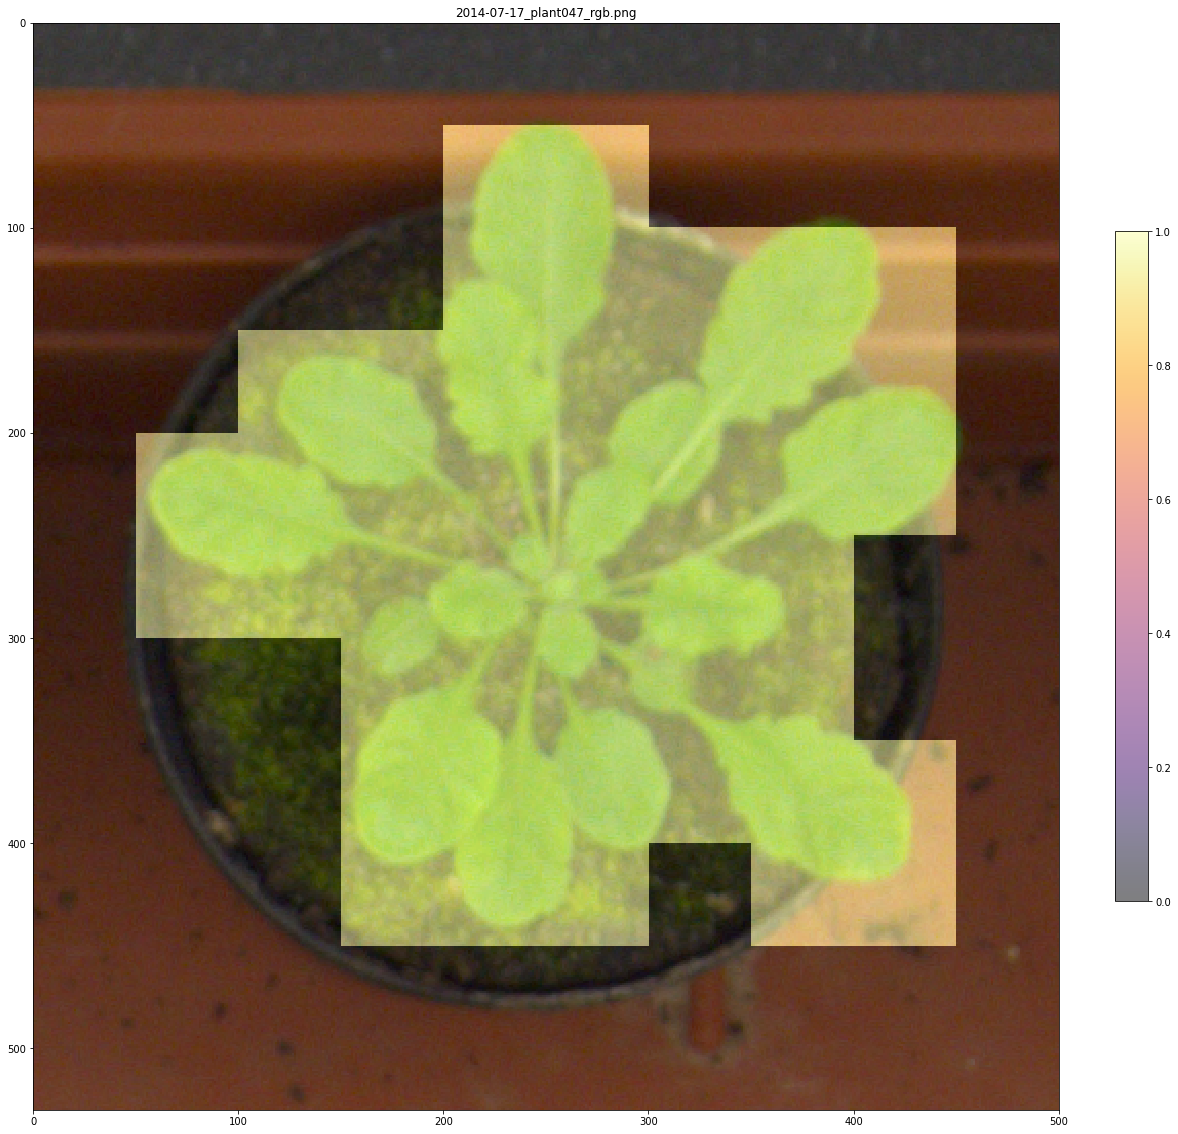

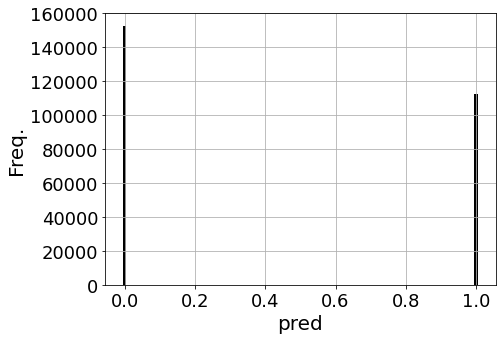

In [30]:
# List of all parents
all_parents = myimgs.list_parents()

myimgs.show_par(all_parents[1], 
                value="pred",
                border=None,
                plot_parent=True,
                vmin=0, vmax=1,
                figsize=(20, 20),
                alpha=0.5, 
                colorbar="inferno")

In [34]:
imgs_pd, patches_pd = myimgs.convertImages(fmt="dataframe")
print(len(patches_pd))
patches_pd.head()

220


,parent_id,image_path,min_x,min_y,max_x,max_y,image_id,pred,conf
patch-0-0-50-50-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50,patch-0-0-50-50-#2014-06-06_plant001_rgb.png#.PNG,0,0.984618
patch-0-0-50-50-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,0,50,50,patch-0-0-50-50-#2014-07-17_plant047_rgb.png#.PNG,0,0.989366
patch-0-100-50-150-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150,patch-0-100-50-150-#2014-06-06_plant001_rgb.pn...,0,0.998607
patch-0-100-50-150-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,100,50,150,patch-0-100-50-150-#2014-07-17_plant047_rgb.pn...,0,0.998475
patch-0-150-50-200-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,C:\Users\ecorcoran\classification_phenotype_te...,0,150,50,200,patch-0-150-50-200-#2014-06-06_plant001_rgb.pn...,0,0.998468


In [35]:
# filter patches with NaNs
patches_filt = patches_pd[~patches_pd["pred"].isna()]
patches_filt = patches_pd[patches_pd["pred"] >= 0]
patches_filt["pred"].value_counts()

0    158
1     62
Name: pred, dtype: int64